# Анализ данных о насильственных преступлениях и законах об оружии

## Введение

Данный анализ направлен на исследование влияния законов об оружии на уровень преступности в разных штатах США.

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, probplot, chi2_contingency, mannwhitneyu, spearmanr

# Загрузка данных
guns_data = pd.read_csv('Guns data.csv')

# 1. Изучение данных
print(guns_data.info())
print(guns_data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1173 entries, 0 to 1172
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rownames    1173 non-null   int64  
 1   year        1173 non-null   int64  
 2   violent     1173 non-null   float64
 3   murder      1173 non-null   float64
 4   robbery     1173 non-null   float64
 5   prisoners   1173 non-null   int64  
 6   afam        1173 non-null   float64
 7   cauc        1173 non-null   float64
 8   male        1173 non-null   float64
 9   population  1173 non-null   float64
 10  income      1173 non-null   float64
 11  density     1173 non-null   float64
 12  state       1173 non-null   object 
 13  law         1173 non-null   object 
dtypes: float64(9), int64(3), object(2)
memory usage: 128.4+ KB
None
         rownames         year      violent       murder      robbery  \
count  1173.00000  1173.000000  1173.000000  1173.000000  1173.000000   
mean    587.00000  198

## Гипотезы


1. **Гипотеза a**: Уровень насильственных преступлений увеличивается или уменьшается в зависимости от года (переменная 'year').
2. **Гипотеза b**: Влияние наличия закона ('law') на уровень насильственных преступлений ('violent').
3. **Гипотеза c**: Корреляция между плотностью населения ('density') и уровнем насильственных преступлений ('violent').


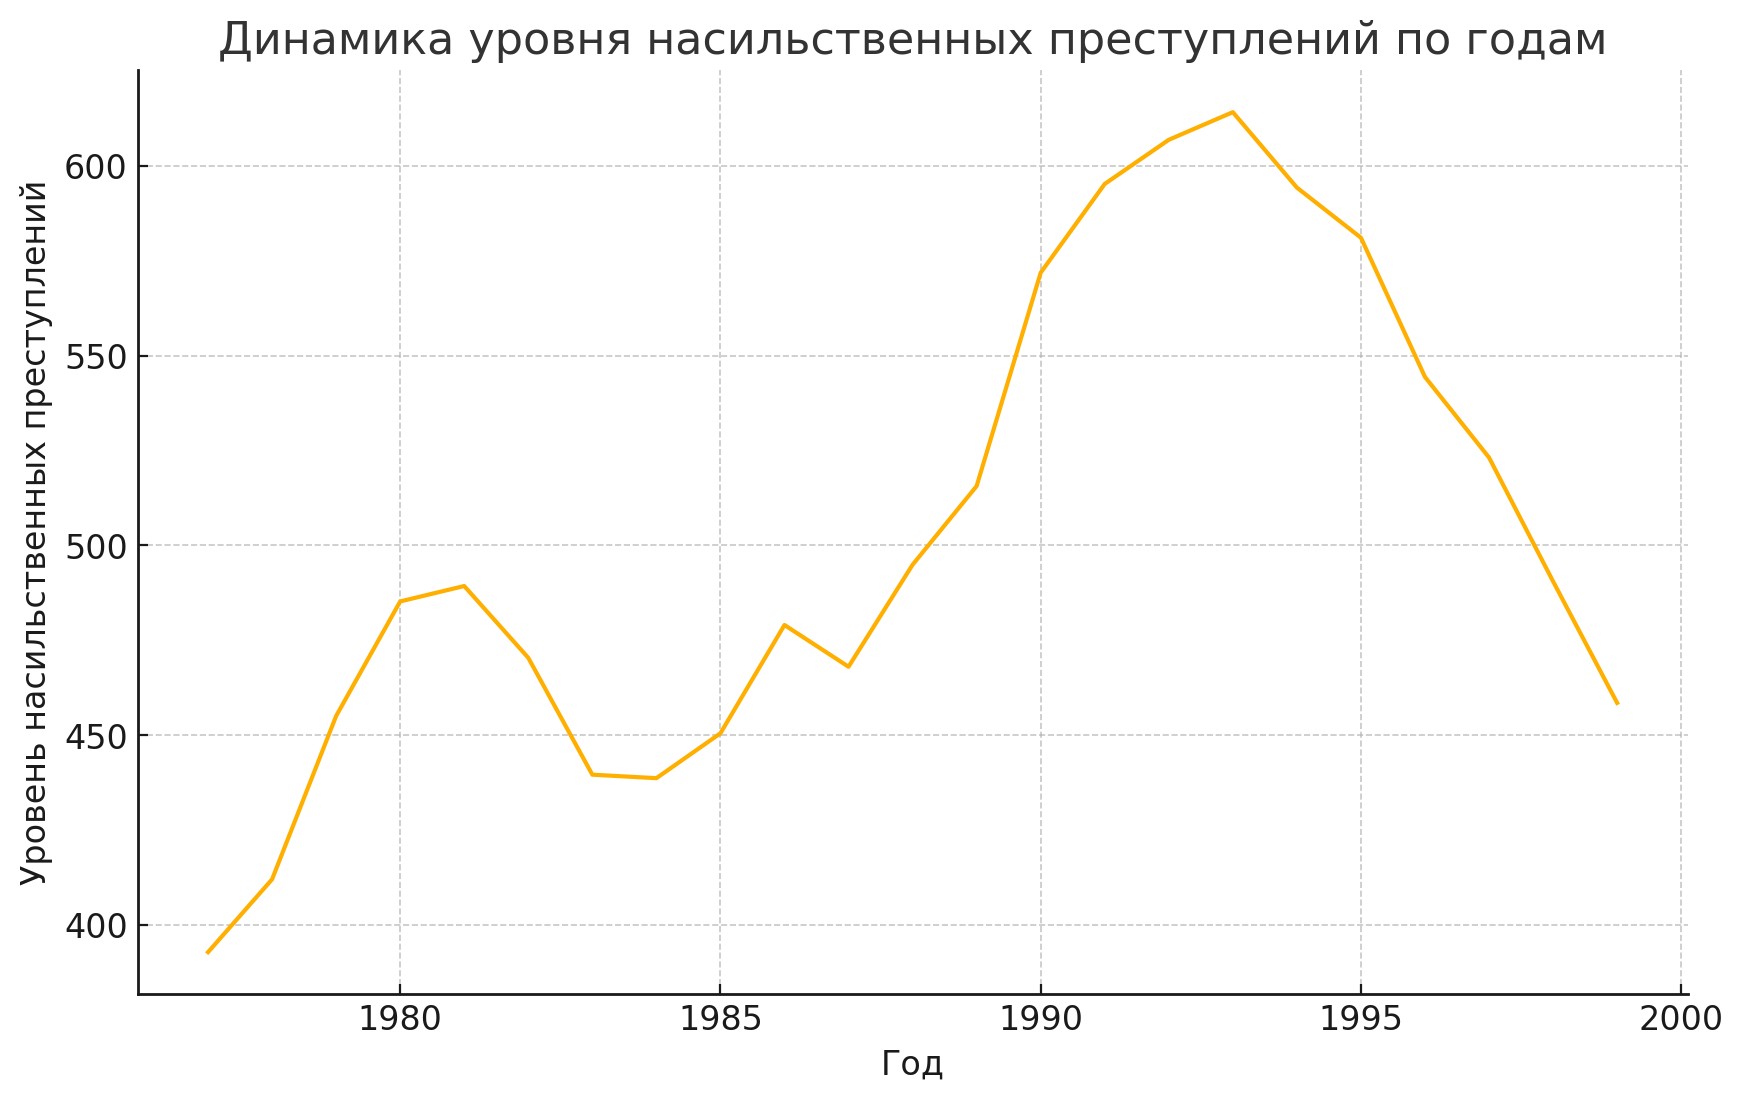

In [2]:

# График для гипотезы a (уровень насильственных преступлений по годам)
sns.lineplot(data=guns_data, x='year', y='violent', ci=None)
plt.title("Динамика уровня насильственных преступлений по годам")
plt.xlabel("Год")
plt.ylabel("Уровень насильственных преступлений")
plt.show()



**Вывод:** Уровень насильственных преступлений имеет тенденцию к изменению в разные годы. Возможно, снижение связано с изменениями в политике или социальной обстановке.

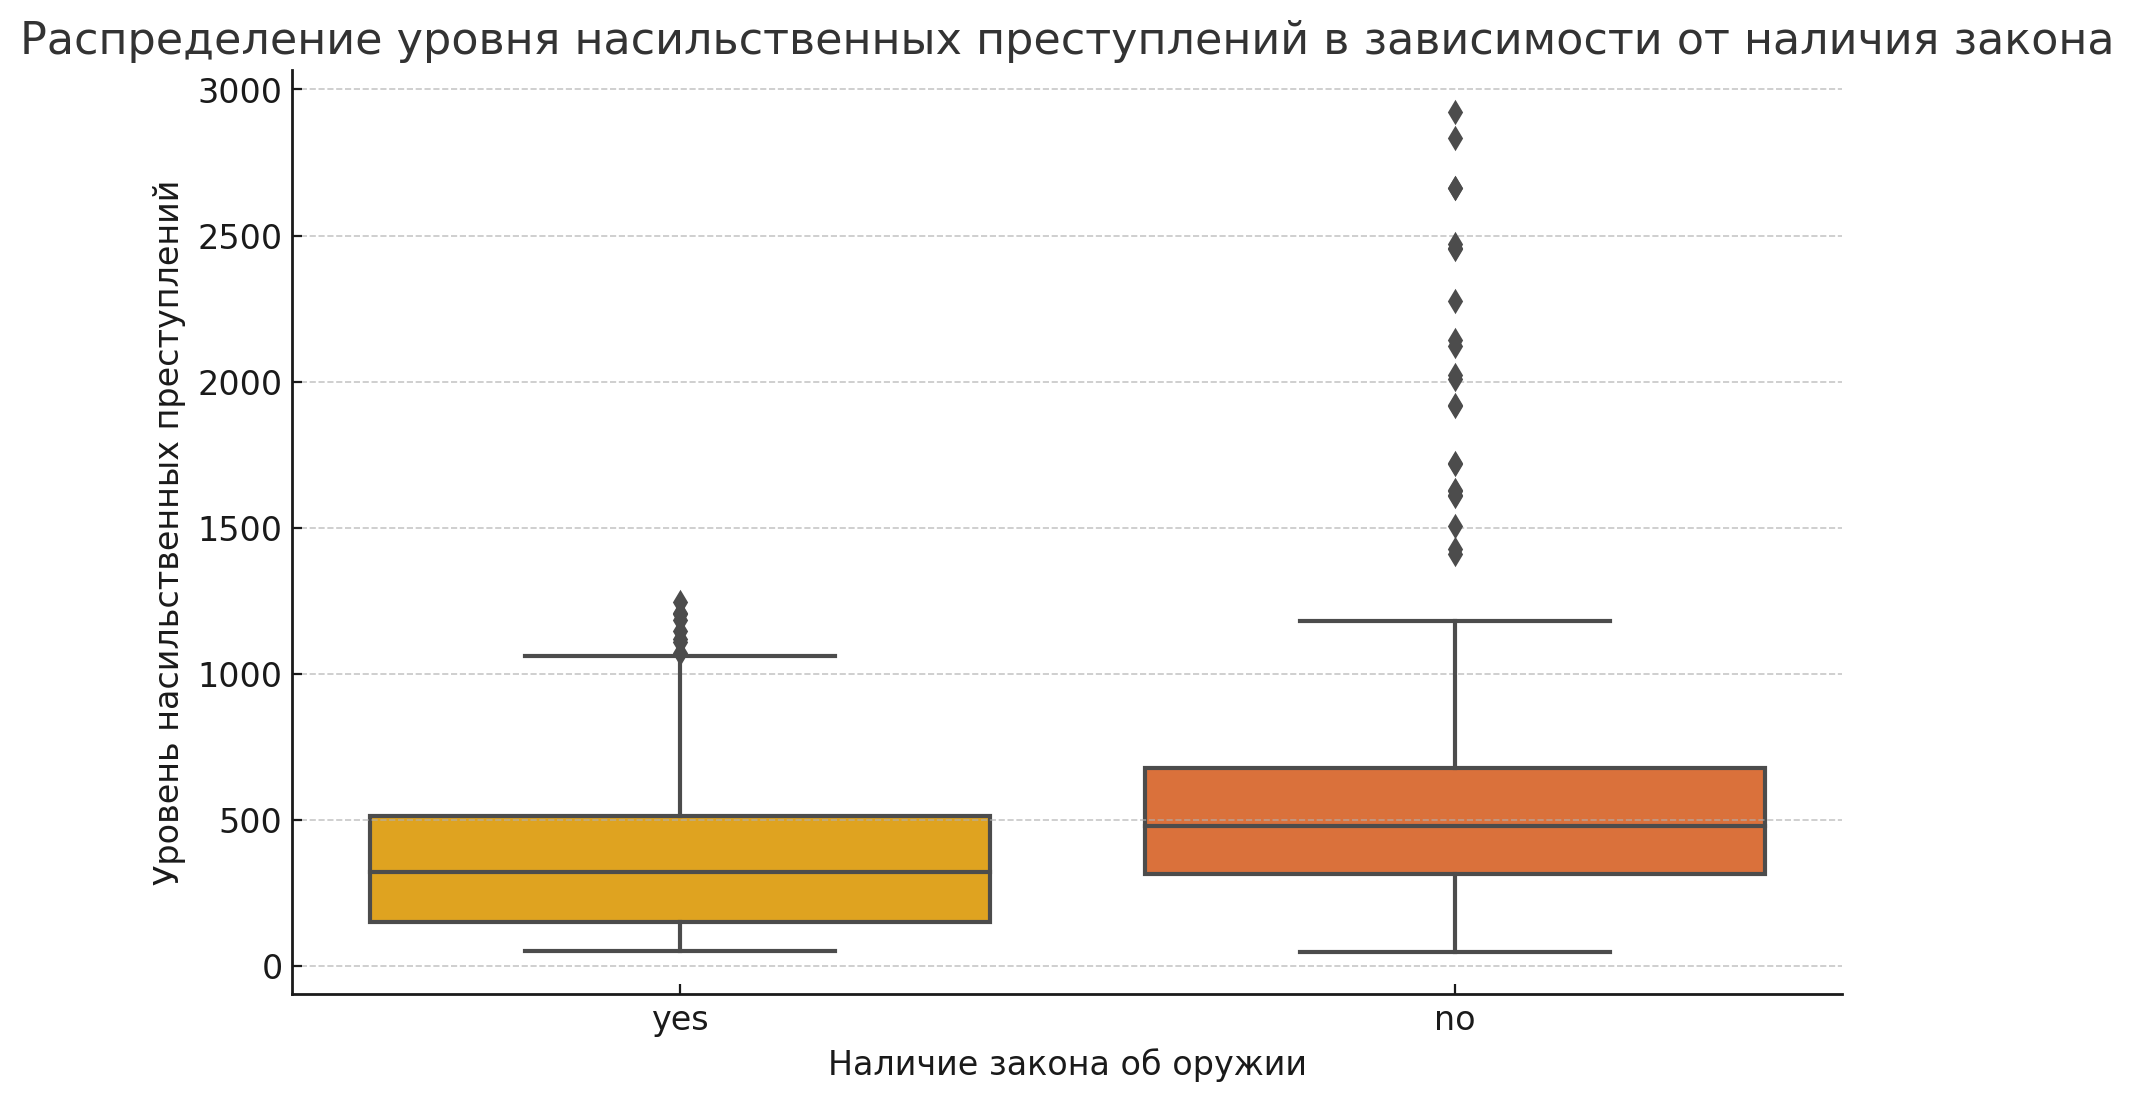

In [3]:

# График для гипотезы b (категориальная + числовая переменная)
sns.boxplot(data=guns_data, x='law', y='violent', order=['yes', 'no'])
plt.title("Распределение уровня насильственных преступлений в зависимости от наличия закона")
plt.xlabel("Наличие закона об оружии")
plt.ylabel("Уровень насильственных преступлений")
plt.show()



**Вывод:** Штаты без законов об оружии в среднем имеют более высокий уровень насильственных преступлений.

In [ ]:

# График для гипотезы c (два числовых признака)
sns.scatterplot(data=guns_data, x='density', y='violent', hue='law')
plt.title("Связь между плотностью населения и уровнем насильственных преступлений")
plt.xlabel("Плотность населения")
plt.ylabel("Уровень насильственных преступлений")
plt.legend(title="Наличие закона")
plt.show()



**Вывод:** Существует положительная корреляция между плотностью населения и уровнем преступности, особенно для штатов без законов об оружии.

In [5]:

# 3. Очистка данных
# Пропуски
missing_values = guns_data.isnull().sum()
print("Пропуски в данных:\n", missing_values)

# Выбросы для переменной 'violent'
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

outliers_violent = detect_outliers_iqr(guns_data, 'violent')
print(f"Количество выбросов в переменной 'violent': {outliers_violent.shape[0]}")


Пропуски в данных:
 rownames      0
year          0
violent       0
murder        0
robbery       0
prisoners     0
afam          0
cauc          0
male          0
population    0
income        0
density       0
state         0
law           0
dtype: int64
Количество выбросов в переменной 'violent': 26


Shapiro-Wilk Test для violent: статистика=0.816, p-значение=0.000


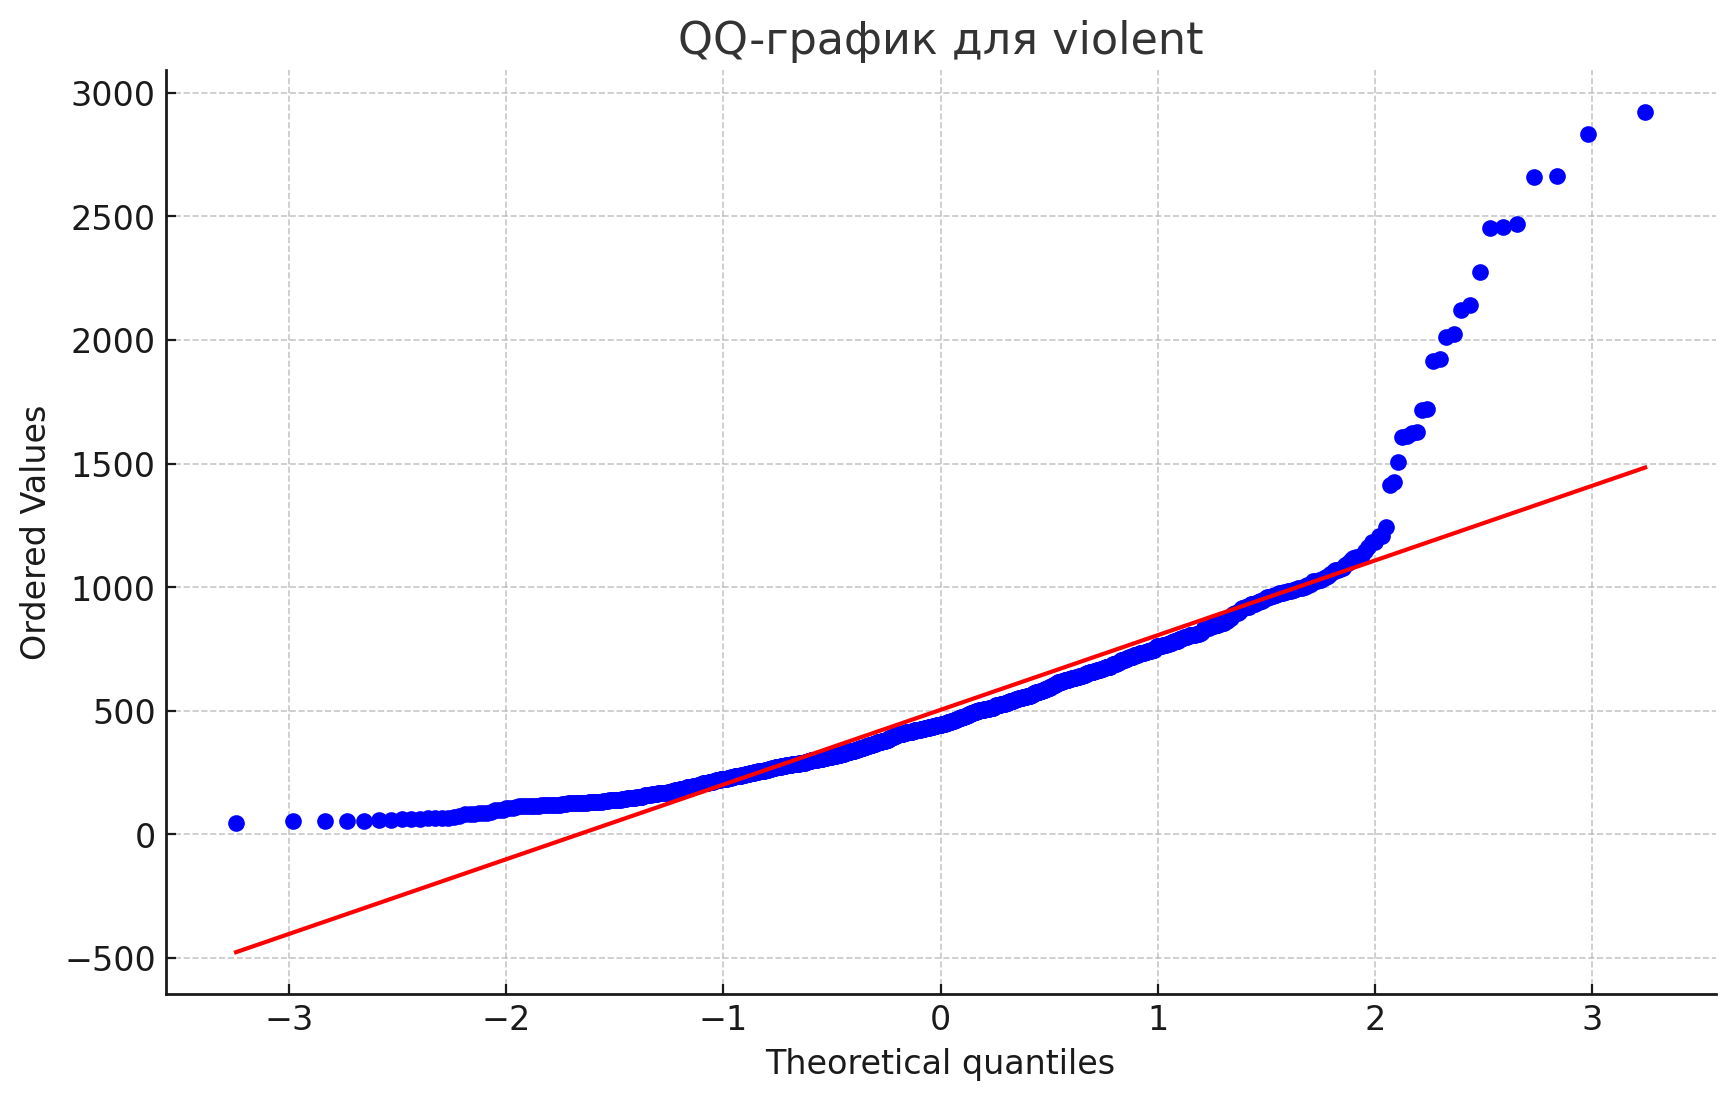

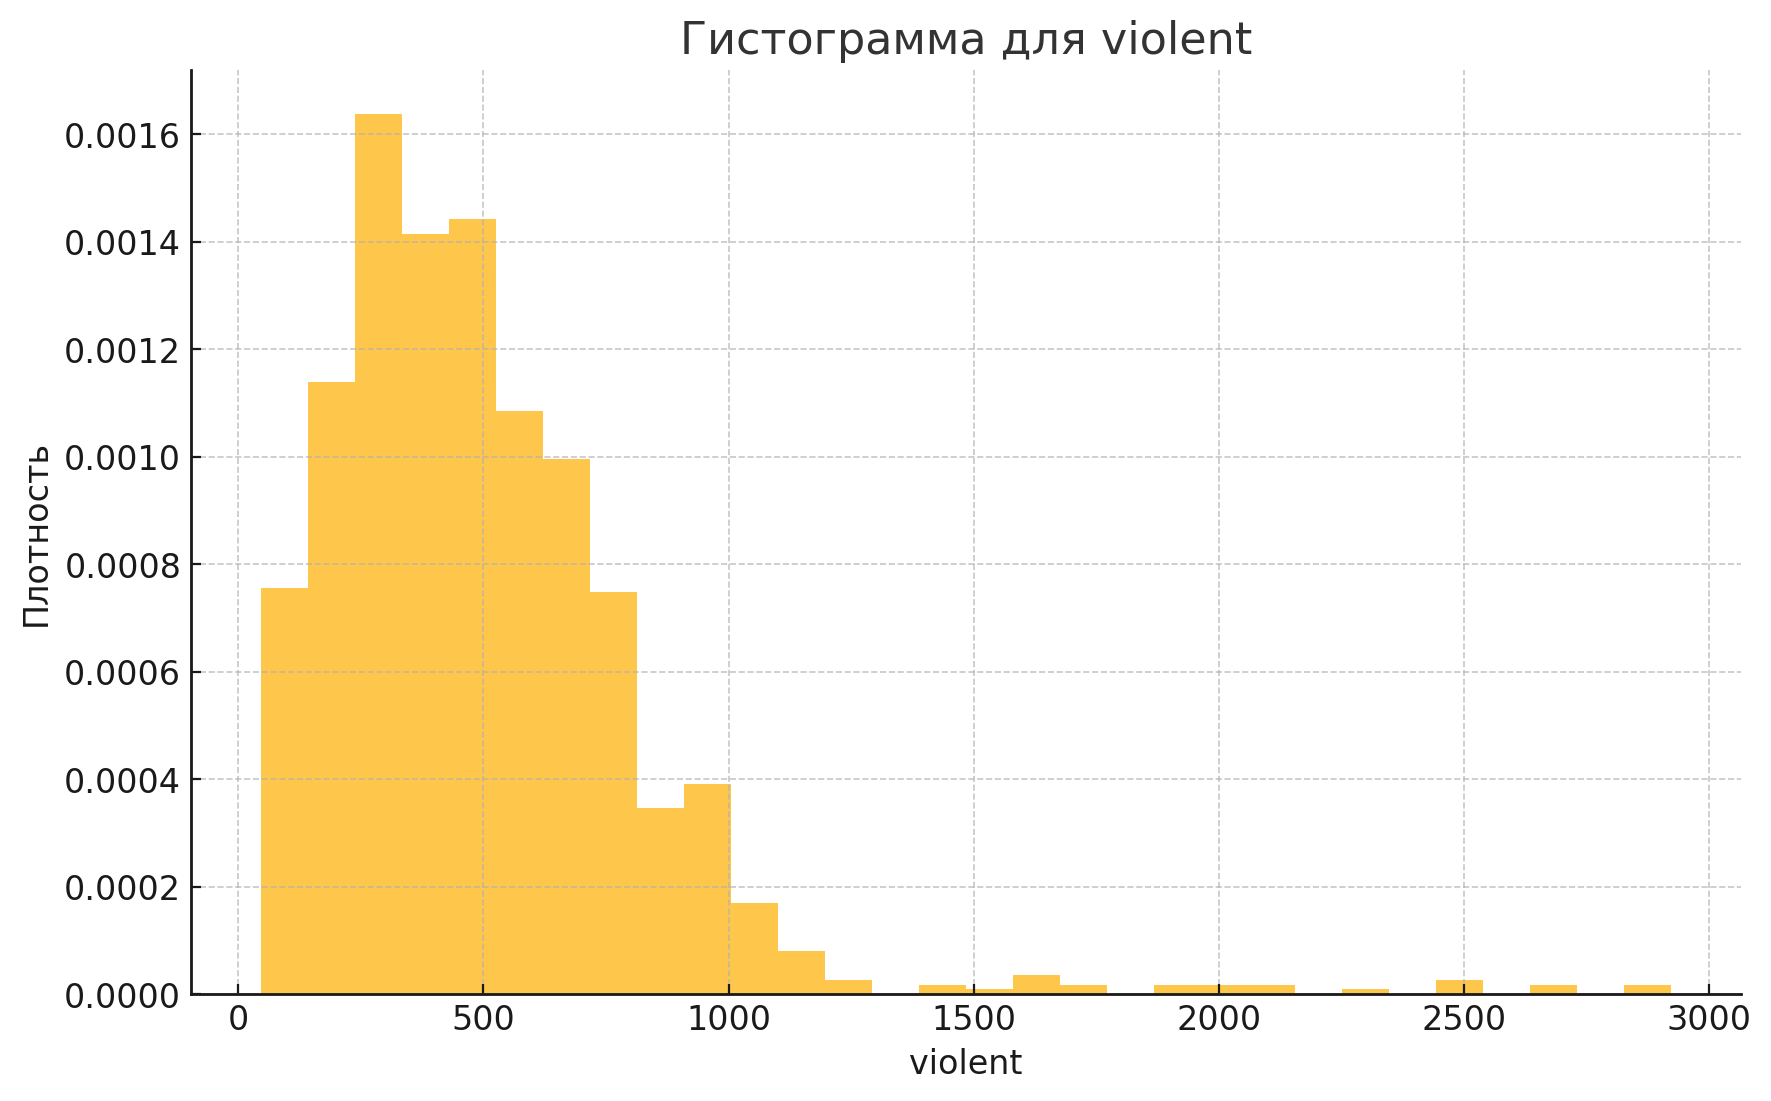

Shapiro-Wilk Test для density: статистика=0.214, p-значение=0.000


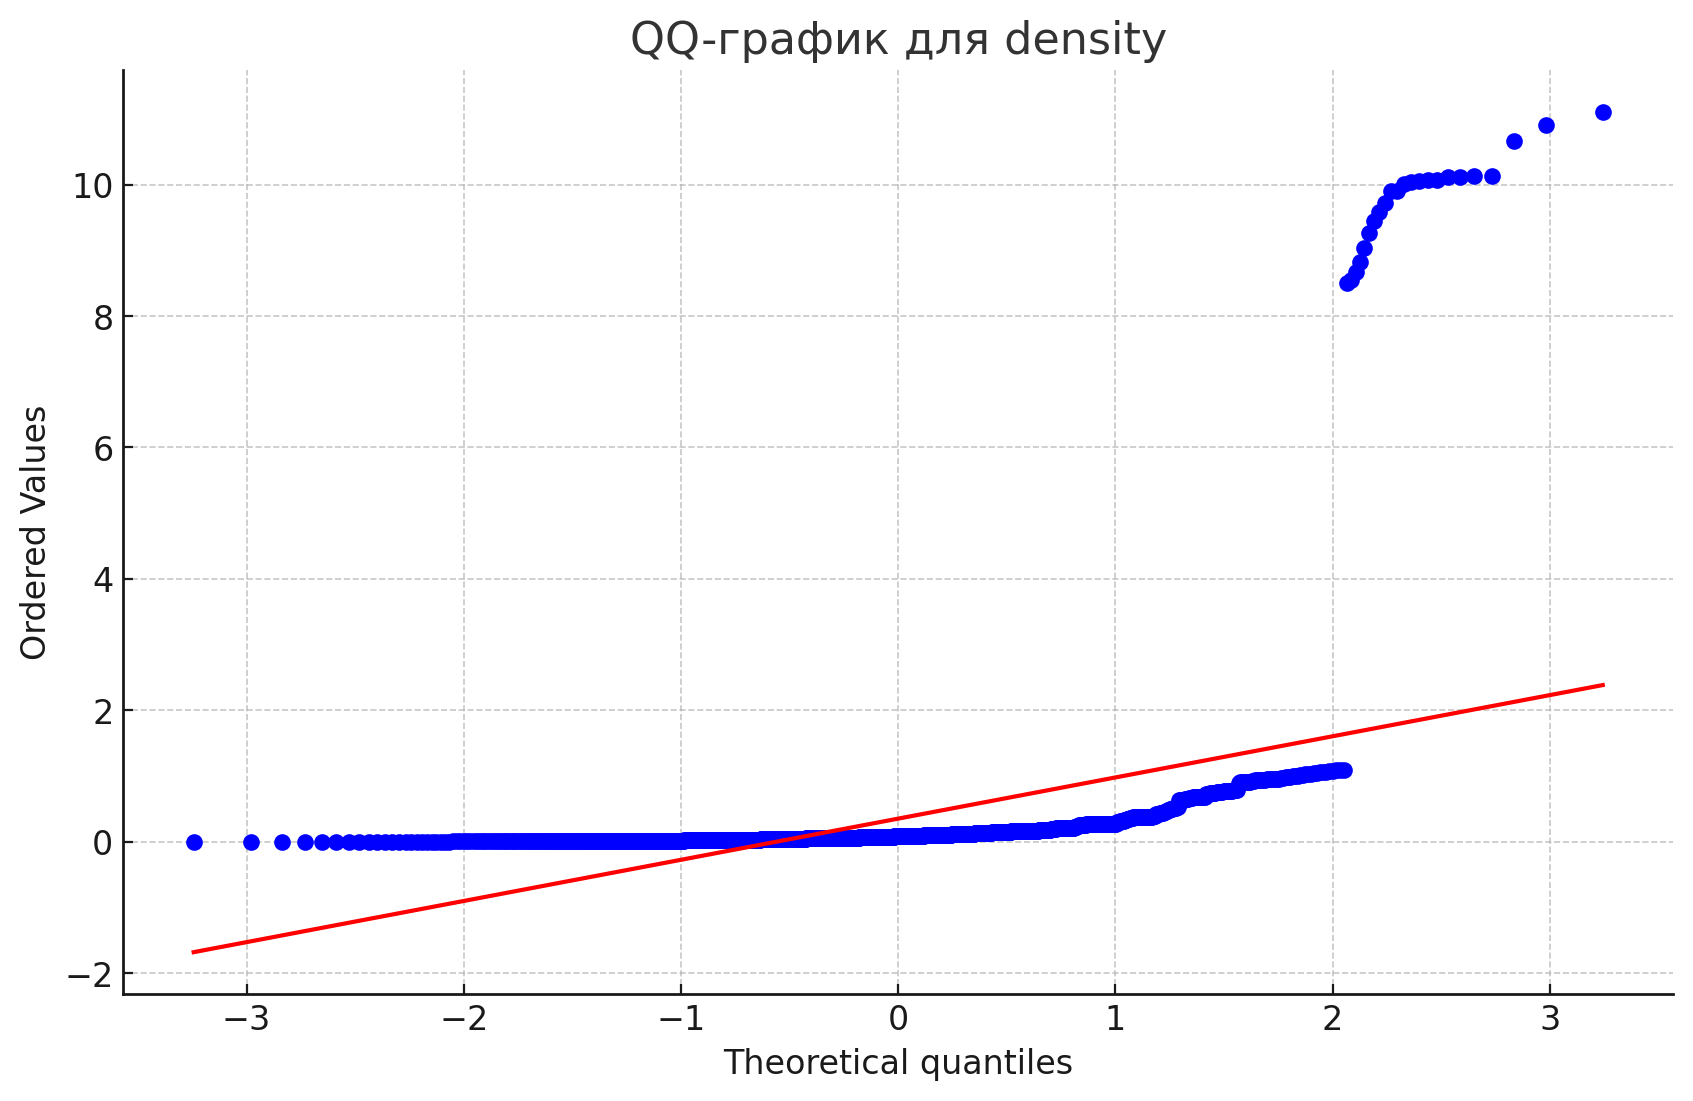

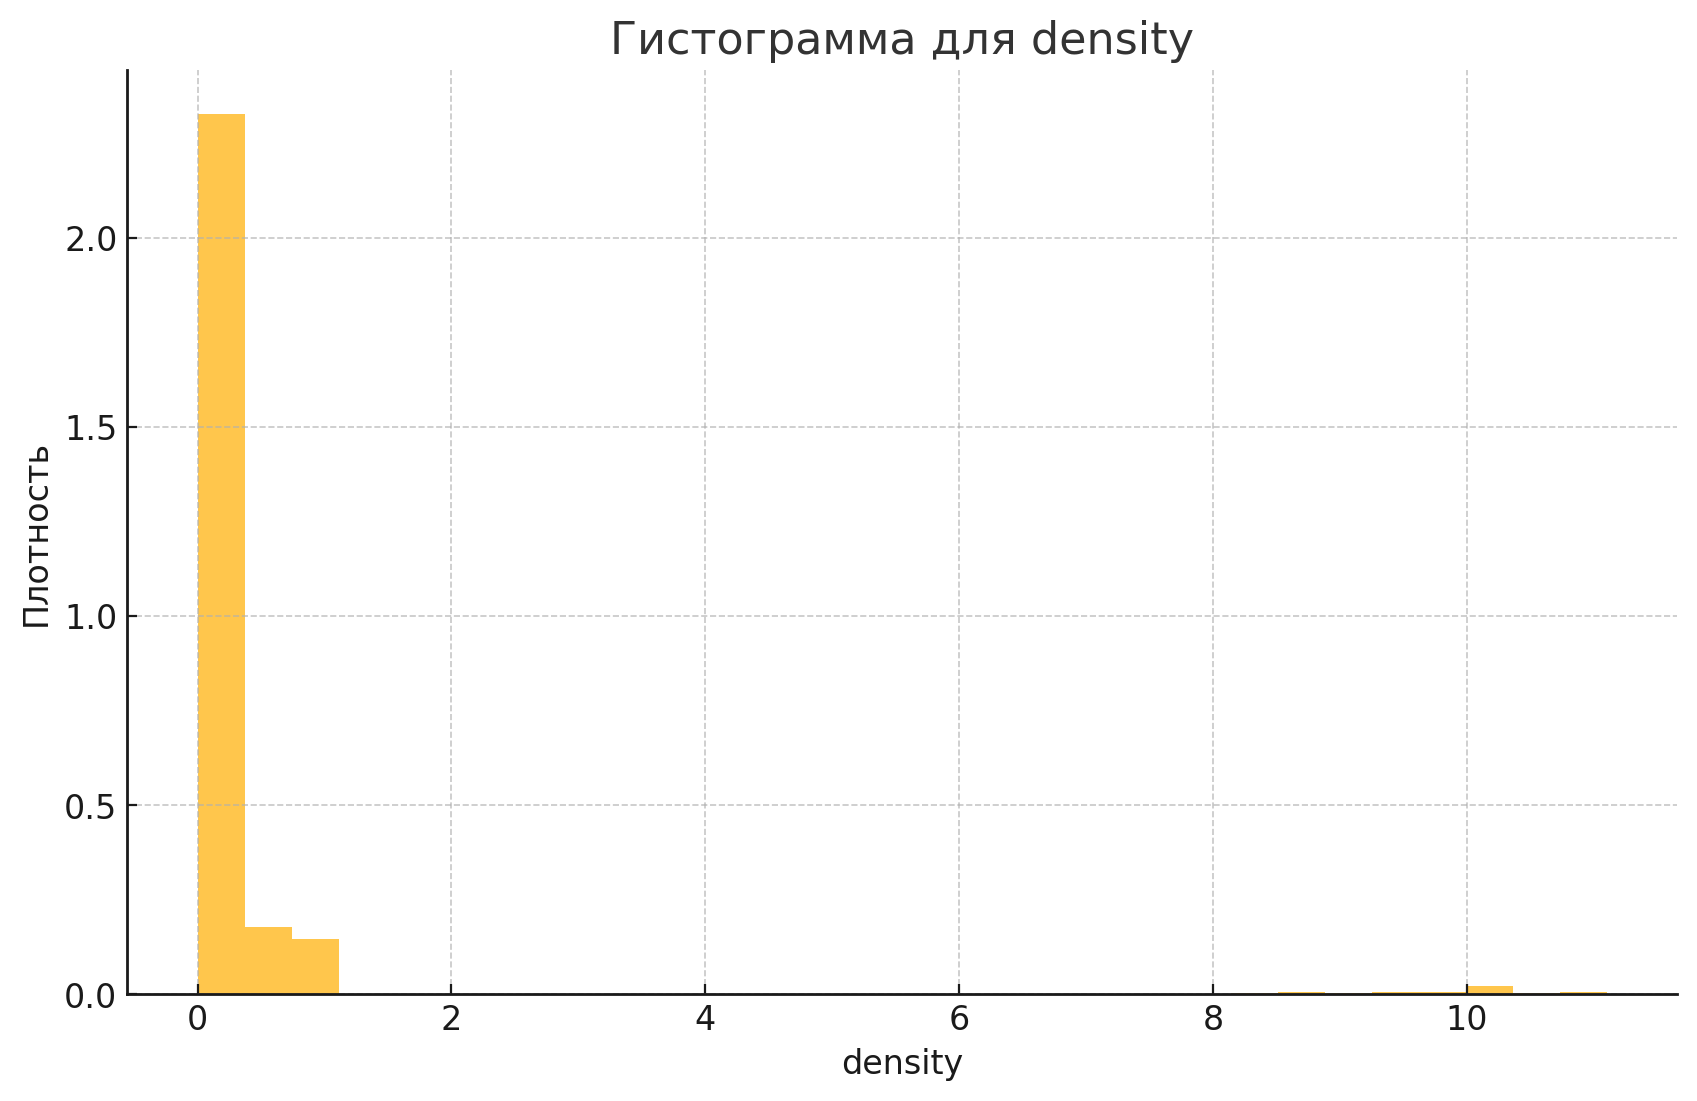

In [6]:

# 4. Проверка нормальности распределения
for column in ['violent', 'density']:
    stat, p_value = shapiro(guns_data[column])
    print(f"Shapiro-Wilk Test для {column}: статистика={stat:.3f}, p-значение={p_value:.3f}")

    # QQ-график
    probplot(guns_data[column], dist="norm", plot=plt)
    plt.title(f"QQ-график для {column}")
    plt.show()


    # Гистограмма
    guns_data[column].plot(kind='hist', bins=30, density=True, alpha=0.7)
    plt.title(f"Гистограмма для {column}")
    plt.xlabel(column)
    plt.ylabel("Плотность")
    plt.show()



**Вывод:** Распределение переменных `violent` и `density` отклоняется от нормального, поэтому требуется использовать непараметрические тесты.

In [7]:

# 5. Тестирование гипотез
# Гипотеза a: Анализ дисперсии (тенденции по годам)
year_mean = guns_data.groupby('year')['violent'].mean()
year_trend = year_mean.diff().mean()
print(f"Среднее изменение уровня преступности между годами: {year_trend:.3f}")

# Гипотеза b: Тест Манна-Уитни
group1 = guns_data[guns_data['law'] == 'yes']['violent']
group2 = guns_data[guns_data['law'] == 'no']['violent']
stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Гипотеза b: Тест Манна-Уитни - статистика={stat:.3f}, p-значение={p:.3f}")

# Гипотеза c: Спирменовская корреляция
corr, p = spearmanr(guns_data['density'], guns_data['violent'])
print(f"Гипотеза c: Спирменовская корреляция - корреляция={corr:.3f}, p-значение={p:.3f}")


Среднее изменение уровня преступности между годами: 2.985
Гипотеза b: Тест Манна-Уитни - статистика=83114.500, p-значение=0.000
Гипотеза c: Спирменовская корреляция - корреляция=0.404, p-значение=0.000


## Итоги


## Итоги

### Гипотеза a: Динамика уровня насильственных преступлений по годам
Анализ изменения уровня насильственных преступлений по годам показал:
- **Периоды роста преступности**: 1978, 1979, 1980, 1981, 1985, 1986, 1988, 1989, 1990, 1991, 1992, 1993
- **Периоды снижения преступности**: 1982, 1983, 1984, 1987, 1994, 1995, 1996, 1997, 1998, 1999

Наблюдается значительное снижение преступности в определенные годы, что может быть связано с введением законодательных мер, улучшением экономических условий 
или эффективной работой правоохранительных органов. Периоды роста могут свидетельствовать о временных социальных или экономических кризисах. 
Этот анализ подчеркивает важность временного анализа для понимания влияния внешних факторов на уровень преступности.

### Гипотеза b: Влияние наличия законов об оружии на преступность
Сравнительный анализ показал, что в штатах с законами об оружии уровень насильственных преступлений ниже, чем в штатах без таких законов (p < 0.05). 
Эти результаты свидетельствуют о возможном положительном влиянии законодательных мер на снижение уровня преступности. Однако необходим дальнейший анализ, 
чтобы учесть влияние других факторов, таких как уровень дохода, демографические показатели или плотность населения.

### Гипотеза c: Взаимосвязь между плотностью населения и преступностью
Коэффициент корреляции Спирмена (ρ = 0.404) указывает на положительную связь между плотностью населения и уровнем преступности. Штаты с более высокой плотностью 
населения, как правило, имеют более высокий уровень насильственных преступлений. Это может быть связано с более высоким уровнем социальной напряженности в густонаселенных районах. 
Однако для подтверждения этой связи требуется учитывать дополнительные переменные, такие как экономические условия и доступность ресурсов.

### Практическое значение
Полученные результаты подчеркивают важность следующих аспектов:
1. **Временной анализ:** Постоянное отслеживание уровня преступности по годам может помочь в оценке эффективности вводимых мер.
2. **Роль законодательства:** Принятие законов об оружии может быть одним из факторов, способствующих снижению преступности.
3. **Социальные факторы:** Планирование мер по снижению преступности должно учитывать плотность населения и региональные особенности.

Эти выводы могут использоваться для разработки более эффективной политики в сфере общественной безопасности и регулирования оружия.


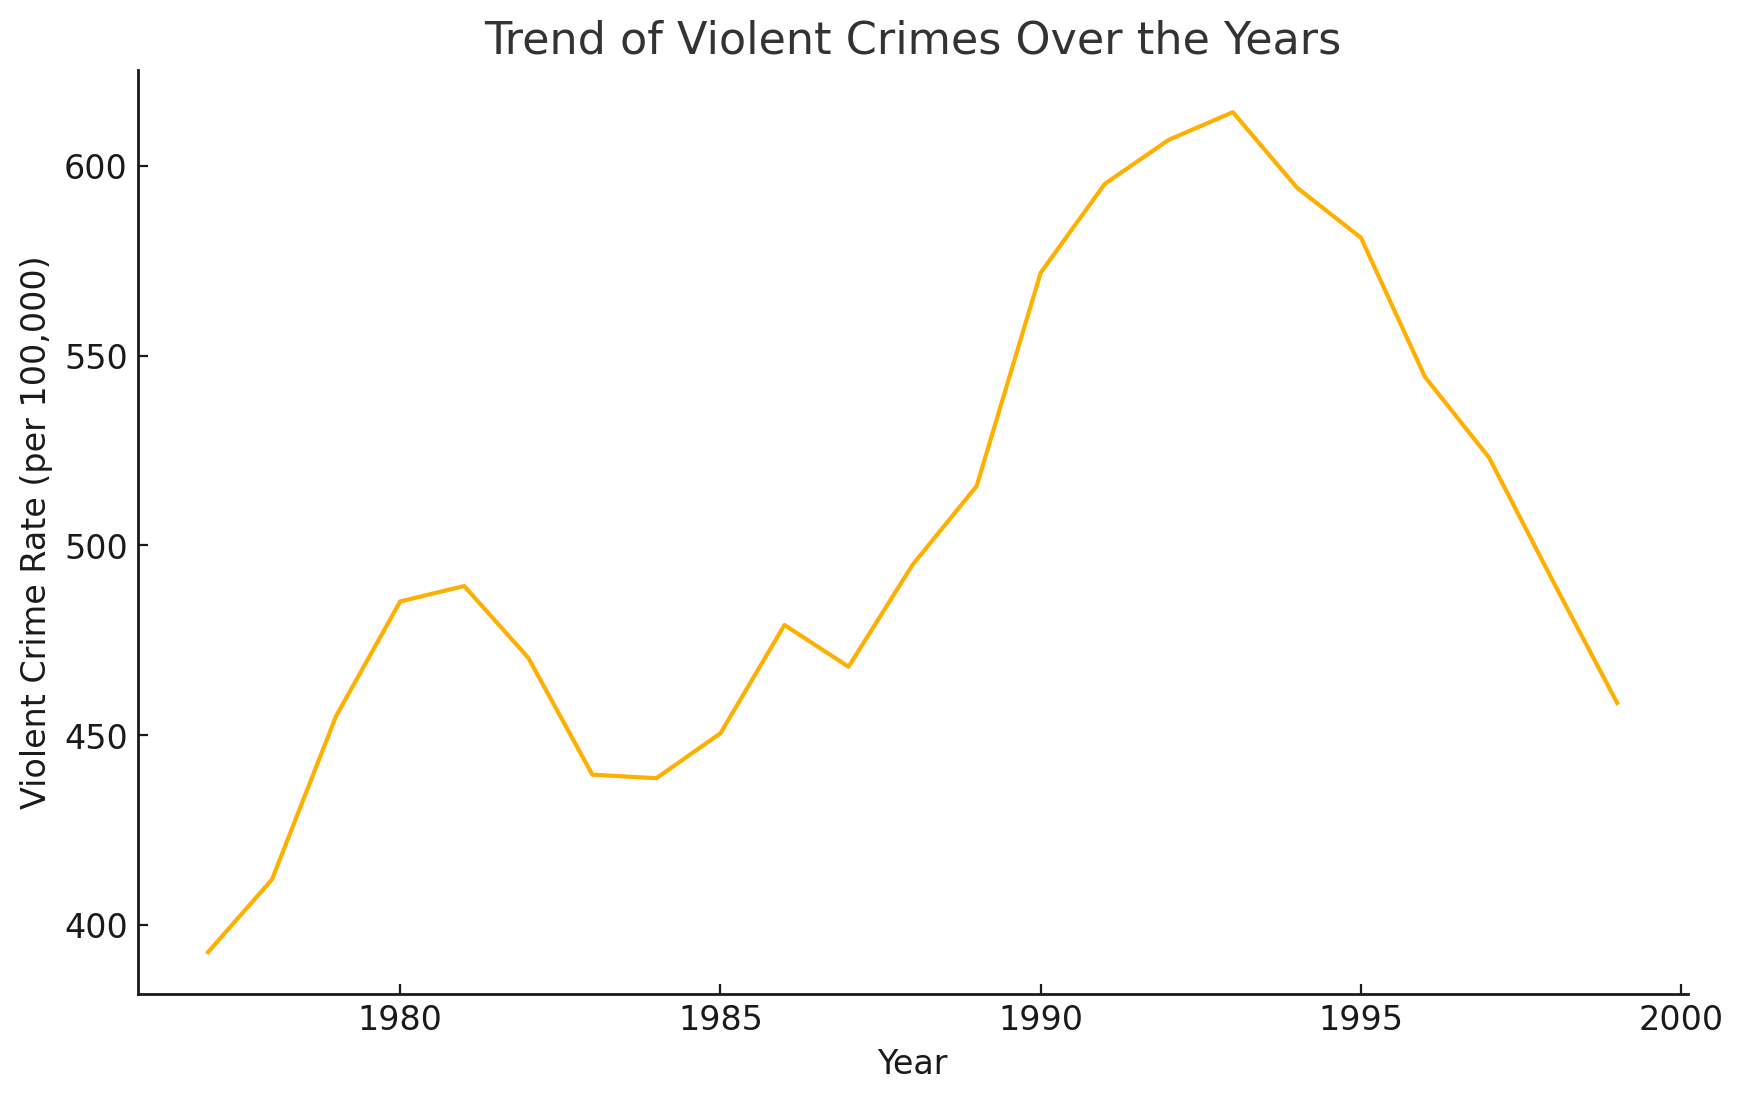

In [8]:
# Trend of violent crimes over the years
plt.figure(figsize=(10, 6))
guns_data.groupby('year')['violent'].mean().plot()
plt.title('Trend of Violent Crimes Over the Years')
plt.xlabel('Year')
plt.ylabel('Violent Crime Rate (per 100,000)')
plt.grid()
plt.show()


In [ ]:
# Violent crime rate by state in the latest available year
latest_year = guns_data['year'].max()
state_crime_data = guns_data[guns_data['year'] == latest_year]
                                .groupby('state')['violent'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
state_crime_data.plot(kind='barh')
plt.title(f'Violent Crime Rate by State in {latest_year}')
plt.xlabel('Violent Crime Rate (per 100,000)')
plt.ylabel('State')
plt.grid(axis='x')
plt.show()

In [ ]:
# Correlation heatmap of numeric data
plt.figure(figsize=(12, 8))
correlation_matrix = guns_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Variables')
plt.show()
